In [197]:
# text manipulation
import re
import string

# Data management
import pandas as pd
import numpy as np
from scipy.sparse import *
import scipy

# NLP
import nltk
import nltk.collocations as collocations
from nltk.tag import tnt
import spacy

# modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import SGDClassifier

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.style as style 

%matplotlib inline

In [2]:
train = pd.read_csv('./train.csv')

In [3]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
train.shape

(1306122, 3)

In [5]:
no_insincere = train[train['target']==1].target.count()
no_sincere = train[train['target']==0].target.count()

print('No. of insincere questions:', no_insincere)
print('No. of sincere questions:', no_sincere)
print('% of insincere questions:', train.target.mean())
print('Null score:', 1- train.target.mean())

No. of insincere questions: 80810
No. of sincere questions: 1225312
% of insincere questions: 0.06187017751787352
Null score: 0.9381298224821265


# Data Cleaning

In [6]:
%%time
# remove digits
clean_questions = (re.sub("[^A-Za-z']+", ' ', q).lower() for q in train['question_text'])

Wall time: 1 ms


In [7]:
stopwords = list(nltk.corpus.stopwords.words('english'))

In [8]:
%%time
# remove stop words and lower all characters
clean_questions = [' '.join(w for w in nltk.word_tokenize(q.lower()) if w not in stopwords) for q in clean_questions]

Wall time: 3min 11s


In [9]:
len(clean_questions)

1306122

In [10]:
train.question_text[1]

'Do you have an adopted dog, how would you encourage people to adopt and not shop?'

In [11]:
clean_questions[:10]

['quebec nationalists see province nation',
 'adopted dog would encourage people adopt shop',
 'velocity affect time velocity affect space geometry',
 'otto von guericke used magdeburg hemispheres',
 'convert montra helicon mountain bike changing tyres',
 'gaza slowly becoming auschwitz dachau treblinka palestinians',
 'quora automatically ban conservative opinions reported liberal views',
 'crazy wash wipe groceries germs everywhere',
 'thing dressing moderately different dressing modestly',
 'ever phase wherein became ignorant people loved completely disregarding feelings lives get something go way feel temporarily ease things change']

# Define functions and pipelines

In [12]:
def vect_trans(vectorizer, X_train, X_test):
    # can also take a transformer
    vect = vectorizer
    vect.fit(X_train)
    return vect.transform(X_train), vect.transform(X_test)

In [234]:
# MultinominalNB function for printing scores and storing into df.
def model_score(model, X_train, X_test, y_train, y_test, score_df, model_label):
    estimator = model
    estimator.fit(X_train, y_train)
    test_score =  estimator.score(X_test, y_test)
    f1 = f1_score(y_test, estimator.predict(X_test))
    
    print('Train Accuracy :', estimator.score(X_train, y_train))
    print('Test Accuracy:', test_score)
    print('Test F1 score:', f1)
    score_df.loc[model_label, 'Test_Accuracy'] = test_score
    score_df.loc[model_label, 'Test_F1_score'] = f1
    return model.predict_proba(X_test)

In [14]:
# Cross Validate function for printing scores and storing into df.
def cv_score(model, X, y, model_label,  cv=5, ):    
    
    # instantiating model
    estimator = model
    
    cv_result = cross_validate(estimator, X, y, cv = cv, n_jobs=-1, scoring=['accuracy', 'f1'])
    
    print('Test Accuracy Mean:',cv_result['test_accuracy'].mean())
    print('Test Accuracy STD:',cv_result['test_accuracy'].std())
    print('Test F1:', cv_result['test_f1'].mean())
    score_df.loc[model_label, 'CV_Accuracy'] = cv_result['test_accuracy'].mean()
    score_df.loc[model_label, 'CV_Acc_STD'] = cv_result['test_accuracy'].std()
    score_df.loc[model_label, 'CV_F1_score'] = cv_result['test_f1'].mean()

In [15]:
# GridSearchCV function, auto display best score and parameters and storing in df
def gridcv(model, X, y, params, cv= 5 ):
    
    # instantiating model can also be a pipeline
    estimator = model
    
    gridcv = GridSearchCV(estimator=estimator, param_grid=params, cv = cv, verbose=10, n_jobs=6)
    gridcv.fit(X, y)
    
    print(gridcv.best_params_)
    print(gridcv.best_score_)
    

In [16]:
# CountVectorizer pipeline and parameters
pipeCVNB = Pipeline([('CV',CountVectorizer(stop_words=stopwords)), 
                    ('NB',MultinomialNB())])

paramsCVNB = {'CV__max_df':(1.0, 0.9, 0.8, 0.7),
       'CV__min_df': (1, 2, 0.01 , 0.1, 0.2),
         'CV__ngram_range':((1,1), (1,2), (1,3))}

In [17]:
# TfidfVectorizer pipeline and parameters
pipeTVNB = Pipeline([('TV',TfidfVectorizer(stop_words=stopwords)), 
                    ('NB',MultinomialNB())])

paramsTVNB = {'TV__max_df':(1.0, 0.9, 0.8, 0.7, 0.6),
       'TV__min_df': (1, 2, 0.01, 0.05, 0.1),
         'TV__ngram_range':((1,1), (1,2), (1,3), (2,2), (2,3))}

In [18]:
score_df = pd.DataFrame()

# Default count vectorizer on raw text

In [198]:
%%time

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(train.question_text, train.target,
                                                                    stratify=train.target, random_state = 495)

X_train_raw_t, X_test_raw_t=  vect_trans(CountVectorizer(), X_train_raw, X_test_raw)

Wall time: 39.3 s


In [232]:
y_test_raw.shape

(326531,)

In [199]:
model = MultinomialNB()
model_label = 'Raw_token_NB'

model_score(model, X_train_raw_t, X_test_raw_t, y_train_raw, y_test_raw, score_df, model_label)
cv_score(model, X_train_raw_t, y_train_raw, model_label)
score_df

Train Accuracy : 0.9350739237089765
Test Accuracy: 0.9344135778838762
Test F1 score: 0.5646092542896641
Test Accuracy Mean: 0.9321614838567932
Test Accuracy STD: 0.0005228593021778298
Test F1: 0.5489215714930169


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.937249,0.556378,0.932654,0.000460,0.530663
Bigram_NB,0.947236,0.396511,0.944596,0.000387,0.481251
Trigram_NB,0.944777,0.271964,0.944946,0.000429,0.508466
Tfidf_t_NB,0.941715,0.147312,0.940417,0.000156,0.111642
Bigram_best_NB,0.937380,0.555924,0.933358,0.000472,0.533960
Trigram_best_NB,0.937387,0.555809,0.933376,0.000463,0.534021
Bigram_best_NB2,0.936706,0.554652,0.932790,0.000515,0.533269
Trigram_best_NB2,0.936729,0.554525,0.932825,0.000510,0.533363


In [200]:
nb = MultinomialNB()
nb.fit(X_train_raw_t, y_train_raw)  
test_score =  nb.score(X_test_raw_t, y_test_raw)
print('train score:', nb.score(X_train_raw_t, y_train_raw))
print('test score:', test_score)
y_pred = nb.predict(X_test_raw_t)

train score: 0.9350739237089765
test score: 0.9344135778838762


In [217]:
Y_pp = pd.DataFrame(nb.predict_proba(X_test_raw_t), columns=['raw_class_0_pp','raw_class_1_pp'])
Y_pp.head()

,raw_class_0_pp,raw_class_1_pp
0,0.999998,0.000002
1,0.999708,0.000292
2,0.985133,0.014867
3,0.999991,0.000009
4,0.031343,0.968657


In [22]:
print(f1_score(y_test_raw, y_pred) )
print(f1_score(y_test_raw, y_pred, average='macro') )
print(f1_score(y_test_raw, y_pred, average='micro') )
print(f1_score(y_test_raw, y_pred, average='weighted') )
confusion_matrix(y_test_raw, y_pred)

0.5646092542896641
0.7645724512273393
0.9344135778838762
0.9397915566837656


array([[291229,  15099],
       [  6317,  13886]], dtype=int64)

# Basic Token and Ngram modelling on cleaned data

Creating train/test sets

In [218]:
X = clean_questions
y = train.target

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 495)

### Tokens only

In [235]:
%%time
X_train_t, X_test_t=  vect_trans(CountVectorizer(max_df=1.0, min_df=1, ngram_range=(1,1)), X_train, X_test)

Wall time: 20.7 s


In [240]:
model = MultinomialNB()
model_label = 'Token_NB'
X_train_arg = X_train_t
X_test_arg = X_test_t

y_pp_temp = model_score(model, X_train_arg, X_test_arg, y_train, y_test, score_df, model_label)
cv_score(model, X_train_arg, y_train, model_label)
score_df

Train Accuracy : 0.937970030349401
Test Accuracy: 0.9372494495162788
Test F1 score: 0.5563782800727461
Test Accuracy Mean: 0.9326535254560504
Test Accuracy STD: 0.0004599552546768383
Test F1: 0.5306632221699109


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.937249,0.556378,0.932654,0.000460,0.530663
Bigram_NB,0.947236,0.396511,0.944596,0.000387,0.481251
Trigram_NB,0.944777,0.271964,0.944946,0.000429,0.508466
Tfidf_t_NB,0.941715,0.147312,0.940417,0.000156,0.111642
Bigram_best_NB,0.937380,0.555924,0.933358,0.000472,0.533960
Trigram_best_NB,0.937387,0.555809,0.933376,0.000463,0.534021
Bigram_best_NB2,0.936706,0.554652,0.932790,0.000515,0.533269
Trigram_best_NB2,0.936729,0.554525,0.932825,0.000510,0.533363


In [233]:
y_test.shape

(326531,)

In [244]:
Y_pp_t = pd.DataFrame(y_pp_temp, columns=['t_class_0_pp','t_class_1_pp'])
Y_pp_t.head() 

,t_class_0_pp,t_class_1_pp
0,0.999992,0.000008
1,0.995851,0.004149
2,0.843648,0.156352
3,0.999997,0.000003
4,0.136639,0.863361


In [ ]:

Y_pp.head()

### All Bigrams

In [372]:
%%time
X_train_bi, X_test_bi=  vect_trans(CountVectorizer(ngram_range=(1,2)), X_train, X_test)

Wall time: 57.3 s


Naive Bayes

In [375]:
model = MultinomialNB()
model_label = 'Bigram_NB'
X_train_arg = X_train_bi
X_test_arg = X_test_bi

model_score(model, X_train_arg, X_test_arg, y_train, y_test, score_df, model_label)
cv_score(model, X_train_arg, y_train, model_label)
score_df


nb = MultinomialNB()
nb.fit(X_train_bi, y_train)  
y_pred = nb.predict(X_test_bi)
confusion_matrix(y_test, y_pred)

Train Accuracy : 0.9743872697891263
Test Accuracy: 0.9472362501569529
Test F1 score: 0.396511261340152
Test Accuracy Mean: 0.944596265646199
Test Accuracy STD: 0.00038680879248805027
Test F1: 0.4812506399709684


array([[303642,   2686],
       [ 14543,   5660]], dtype=int64)

Random Forest

In [29]:
# %%time
# model = RandomForestClassifier(n_estimators= 100, max_depth=20, n_jobs=-1)
# model_label = 'Bigram_RF'


# model_score(model, X_train_bi, X_test_bi, y_train, y_test, score_df, model_label)
# cv_score(model, X_train_bi, y_train, model_label)
# score_df

In [30]:
# score_df

### Tri-gram

In [31]:
%%time
X_train_tri, X_test_tri=  vect_trans(CountVectorizer(ngram_range=(1,3), stop_words=stopwords), X_train, X_test)

Wall time: 1min 33s


Naive Bayes

In [32]:
model = MultinomialNB()
model_label = 'Trigram_NB'
X_train_arg = X_train_tri
X_test_arg = X_test_tri

model_score(model, X_train_arg, X_test_arg, y_train, y_test, score_df, model_label)
cv_score(model, X_train_arg, y_train, model_label)
score_df

Train Accuracy : 0.9879398646986345
Test Accuracy: 0.9447770655772346
Test F1 score: 0.2719638242894057
Test Accuracy Mean: 0.9449464117400644
Test Accuracy STD: 0.0004286953649944555
Test F1: 0.5084657241073491


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.937249,0.556378,0.932654,0.000460,0.530663
Bigram_NB,0.947236,0.396511,0.944596,0.000387,0.481251
Trigram_NB,0.944777,0.271964,0.944946,0.000429,0.508466


Random Forest

In [33]:
# %%time
# model = RandomForestClassifier(n_estimators= 100, max_depth=20, n_jobs=-1)
# model_label = 'Trigram_RF'

# model_score(model, X_train_tri, X_test_tri, y_train, y_test, score_df, model_label)
# cv_score(model, X_train_tri, y_train, model_label)


In [34]:
# score_df

### GridSearch min/max df

In [35]:
# params = {'CV__max_df':(1.0, 0.9),
#        'CV__min_df': (1, 2, 0.01, 0.02),
#         'CV__ngram_range':((1,1), (1,2), (1,3))}

# gridcv(pipeCVNB, X_train, y_train, params)

In [36]:
# %%time
# X_train_t, X_test_t=  vect_trans(CountVectorizer(max_df=1.0, min_df=1, ngram_range=(1,2), 
#                                                     stop_words=stopwords), X_train, X_test)

In [37]:
# model = MultinomialNB()
# model_label = 'Grid_DFNB'

# model_score(model, X_train_t, X_test_t, y_train, y_test, score_df, model_label)
# cv_score(model, X_train_t, y_train, model_label)
# score_df

### TFIDF

In [249]:
X_train_tf_t, X_test_tf_t = vect_trans(TfidfTransformer(), X_train_t, X_test_t)

In [250]:
model = MultinomialNB()
model_label = 'Tfidf_t_NB'

y_pp_temp = model_score(model, X_train_tf_t , X_test_tf_t, y_train, y_test, score_df, model_label)
cv_score(model, X_train_tf_t, y_train, model_label)
score_df

Train Accuracy : 0.9430742013758804
Test Accuracy: 0.941714569213949
Test F1 score: 0.14731182795698924
Test Accuracy Mean: 0.9404169704054887
Test Accuracy STD: 0.00015593287984500654
Test F1: 0.11164182032179673


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.937249,0.556378,0.932654,0.000460,0.530663
Bigram_NB,0.947236,0.396511,0.944596,0.000387,0.481251
Trigram_NB,0.944777,0.271964,0.944946,0.000429,0.508466
Tfidf_t_NB,0.941715,0.147312,0.940417,0.000156,0.111642
Bigram_best_NB,0.937380,0.555924,0.933358,0.000472,0.533960
Trigram_best_NB,0.937387,0.555809,0.933376,0.000463,0.534021
Bigram_best_NB2,0.936706,0.554652,0.932790,0.000515,0.533269
Trigram_best_NB2,0.936729,0.554525,0.932825,0.000510,0.533363


In [251]:
Y_pp_tfidf = pd.DataFrame(y_pp_temp, columns=['tfidf_class_0_pp','tfidf_class_1_pp'])
Y_pp_tfidf.head() 

,tfidf_class_0_pp,tfidf_class_1_pp
0,0.999497,0.000503
1,0.988978,0.011022
2,0.904789,0.095211
3,0.997957,0.002043
4,0.700050,0.299950


In [40]:
nb = MultinomialNB()
nb.fit(X_train_tf_t, y_train)  
test_score =  nb.score(X_test_tf_t, y_test)
print('train score:', nb.score(X_train_tf_t, y_train))
print('test score:', test_score)
y_pred = nb.predict(X_test_tf_t)

train score: 0.9430742013758804
test score: 0.941714569213949


In [41]:
print(f1_score(y_test, y_pred) )
print(f1_score(y_test, y_pred, average='macro') )
print(f1_score(y_test, y_pred, average='micro') )
print(f1_score(y_test, y_pred, average='weighted') )
confusion_matrix(y_test, y_pred)

0.14731182795698924
0.5585689211985624
0.941714569213949
0.9189357341619414


array([[305855,    473],
       [ 18559,   1644]], dtype=int64)

### NLTK Best Bigrams

In [42]:
# recreate text using ngrams
def ngram_to_corpus(data, ngram_list, n):
#     ngram_list = set({('let', 'us'), ('as', 'soon')})  # {('let', 'us'), ('as', 'soon')}
#     tokens = ['please', 'let', 'us', 'know', 'as', 'soon', 'as', 'possible']
    new_data = []
    for text in data:
        tokens = nltk.word_tokenize(text)
        output = []
        q_iter = iter(range(len(tokens)))
        
        for idx in q_iter:
            output.append(tokens[idx])
            if n == 2:
                if idx < (len(tokens) - 1) and (tokens[idx], tokens[idx+1]) in ngram_list:
                    output[-1] += '_' + tokens[idx+1]
                    next(q_iter)
            elif n == 3:
                if idx < (len(tokens) - 2) and (tokens[idx], tokens[idx+1], tokens[idx+2] ) in ngram_list:
                    output[-1] += '_' + tokens[idx+1] + '_' + tokens[idx+2]
                    next(q_iter)
                    next(q_iter)
        new_data.append( ' '.join(output))

    return new_data

In [43]:
%%time
# create one list of all question tokens
full_text = []

for text in X_train:
    full_text += [w for w in nltk.word_tokenize(text) if w not in stopwords]

Wall time: 1min 52s


In [44]:
len(full_text)

6384395

In [45]:
if 'would' in stopwords:
    print(True)

In [46]:
%%time
# create bigram vocabulary
bigram_measures = collocations.BigramAssocMeasures()

finder = nltk.BigramCollocationFinder.from_words(full_text)
# scored = finder.score_ngrams( bigram_measures.likelihood_ratio  )
bigram_lkhd = finder.nbest(bigram_measures.likelihood_ratio, 80)
print(bigram_lkhd)

[('ca', "n't"), ('united', 'states'), ('year', 'old'), ('best', 'way'), ('donald', 'trump'), ('computer', 'science'), ('even', 'though'), ('high', 'school'), ('social', 'media'), ('would', 'happen'), ('north', 'korea'), ('pros', 'cons'), ('get', 'rid'), ('major', 'accomplishments'), ('jee', 'mains'), ('look', 'like'), ('wo', "n't"), ('would', 'win'), ('x', 'x'), ('new', 'york'), ('machine', 'learning'), ('harry', 'potter'), ('years', 'old'), ('real', 'estate'), ('ssc', 'cgl'), ('long', 'take'), ('saudi', 'arabia'), ('feel', 'like'), ('star', 'wars'), ('long', 'term'), ('mechanical', 'engineering'), ('elon', 'musk'), ('tv', 'show'), ('e', 'g'), ('hillary', 'clinton'), ('hong', 'kong'), ('tamil', 'nadu'), ('short', 'term'), ('useful', 'tips'), ('president', 'trump'), ('san', 'francisco'), ('b', 'tech'), ('artificial', 'intelligence'), ('prime', 'minister'), ('different', 'types'), ('tv', 'series'), ('years', 'ago'), ('credit', 'card'), ('literary', 'devices'), ('narendra', 'modi'), ('new

In [47]:
%%time
# create bigram vocabulary
bigram_measures = collocations.BigramAssocMeasures()


finder = nltk.BigramCollocationFinder.from_words(full_text)
finder.apply_freq_filter(10)
bigram_pmi = finder.nbest(bigram_measures.pmi, 200)
print(bigram_pmi)

[('schr', 'dinger'), ('pepto', 'bismol'), ('michio', 'kaku'), ('muhoozi', 'kainerugaba'), ('neman', 'ashraf'), ('roald', 'dahl'), ('rudyard', 'kipling'), ('avada', 'kedavra'), ('aam', 'aadmi'), ('buenos', 'aires'), ('jaggi', 'vasudev'), ('disha', 'patani'), ('ronda', 'rousey'), ('abercrombie', 'fitch'), ('mosin', 'nagant'), ('zaira', 'wasim'), ('endoplasmic', 'reticulum'), ('deng', 'xiaoping'), ('gilgit', 'baltistan'), ('nathuram', 'godse'), ('sushma', 'swaraj'), ('jiang', 'zemin'), ('vande', 'mataram'), ('meryl', 'streep'), ('pakatan', 'harapan'), ('asim', 'qureshi'), ('sylvia', 'plath'), ('lata', 'mangeshkar'), ('kalpit', 'veerwal'), ('dima', 'vorobiev'), ('sindhu', 'satish'), ('pradhan', 'mantri'), ('aldous', 'huxley'), ('narsee', 'monjee'), ('ulcerative', 'colitis'), ('gauri', 'lankesh'), ('hadron', 'collider'), ('ballon', "d'or"), ('jiu', 'jitsu'), ('shel', 'silverstein'), ('mitt', 'romney'), ('khaled', 'hosseini'), ('petyr', 'baelish'), ('sourav', 'ganguly'), ('satoshi', 'nakamot

In [48]:
bigram_vocab = list(set(bigram_lkhd + bigram_pmi))

In [49]:
len(bigram_vocab)

280

In [50]:
%%time
# create trigram vocabulary
trigram_measures = collocations.TrigramAssocMeasures()
finder = nltk.TrigramCollocationFinder.from_words(full_text)
trigram_lkhd = finder.nbest(trigram_measures.likelihood_ratio, 40)
print(trigram_lkhd)

[('ca', "n't", 'want'), ('ca', "n't", 'know'), ('ca', "n't", 'like'), ('ca', "n't", 'see'), ('ca', "n't", 'understand'), ('ca', "n't", 'care'), ('ca', "n't", 'afford'), ('ca', "n't", 'even'), ('ca', "n't", 'get'), ('ca', "n't", 'seem'), ('ca', "n't", 'find'), ('ca', "n't", 'feel'), ('ca', "n't", 'exist'), ('ca', "n't", 'believe'), ('ca', "n't", 'remember'), ('ca', "n't", 'let'), ('ca', "n't", 'stop'), ('ca', "n't", "'s"), ('ca', "n't", 'talk'), ('ca', "n't", 'think'), ('ca', "n't", 'would'), ('ca', "n't", 'use'), ('ca', "n't", 'best'), ('ca', "n't", 'speak'), ('ca', "n't", 'liberals'), ('ca', "n't", 'go'), ('ca', "n't", 'people'), ('even', 'ca', "n't"), ('ca', "n't", 'stand'), ('ca', "n't", 'give'), ('ca', "n't", 'need'), ('ca', "n't", 'accept'), ('ca', "n't", 'really'), ('best', 'ca', "n't"), ('ca', "n't", 'make'), ('ca', "n't", 'matter'), ('ca', "n't", 'realize'), ('ca', "n't", 'work'), ('ca', "n't", 'trust'), ('ca', "n't", 'allow')]
Wall time: 8min 24s


In [51]:
%%time
# create trigram vocabulary
trigram_measures = collocations.TrigramAssocMeasures()
finder = nltk.TrigramCollocationFinder.from_words(full_text)
finder.apply_freq_filter(10)
trigram_pmi = finder.nbest(trigram_measures.pmi, 40)
print(trigram_pmi)

[('ku', 'klux', 'klan'), ('atal', 'bihari', 'vajpayee'), ('ralph', 'waldo', 'emerson'), ('ravindra', 'babu', 'ravula'), ('edgar', 'allan', 'poe'), ('guru', 'granth', 'sahib'), ('tic', 'tac', 'toe'), ('netaji', 'subhash', 'chandra'), ('jamia', 'millia', 'islamia'), ('jamia', 'milia', 'islamia'), ('neil', 'degrasse', 'tyson'), ('subhash', 'chandra', 'bose'), ('apj', 'abdul', 'kalam'), ('osama', 'bin', 'laden'), ('lana', 'del', 'rey'), ('ho', 'chi', 'minh'), ('vincent', 'van', 'gogh'), ('ram', 'nath', 'kovind'), ('leonardo', 'da', 'vinci'), ('jar', 'jar', 'binks'), ('gurmeet', 'ram', 'rahim'), ('dr', 'vinay', 'kumaran'), ('yu', 'gi', 'oh'), ('grand', 'admiral', 'thrawn'), ('rio', 'de', 'janeiro'), ('obi', 'wan', 'kenobi'), ('sarah', 'huckabee', 'sanders'), ('iiit', 'naya', 'raipur'), ('aam', 'aadmi', 'party'), ('nvidia', 'geforce', 'gt'), ('walter', 'dean', 'myers'), ('icc', 'champions', 'trophy'), ('swollen', 'lymph', 'nodes'), ('aloe', 'vera', 'gel'), ('shah', 'rukh', 'khan'), ('bashar'

In [52]:
trigram_vocab = list(set(trigram_lkhd + trigram_pmi))
len(trigram_vocab)

80

In [53]:
%%time
# create text with bigram replacement
train['bigram_question_lkhd'] = ngram_to_corpus(clean_questions, bigram_vocab, 2)

Wall time: 3min 24s


In [54]:
%%time
# create text with both tri and bigram in text, by applying trigram first
train['trigram_question_lkhd'] = ngram_to_corpus(clean_questions, trigram_vocab, 3)
train['trigram_question_lkhd'] = ngram_to_corpus(train['trigram_question_lkhd'], bigram_vocab, 2)

Wall time: 5min 54s


In [55]:
train['trigram_question_lkhd'][20:25].values

array(['know whether girl done sex sex',
       'become fast learner professional career personal life',
       'united_states become largest dictatorship world',
       'strangest phenomenon know witnessed generated area electronics explanation terms modern physics',
       'leave friends find new ones'], dtype=object)

In [56]:
X = train[['bigram_question_lkhd','trigram_question_lkhd']]
y = train.target

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=495, test_size=0.2)

In [58]:
len(X_train)

1044897

#### Bigram Model

In [59]:
# model using bigram text
X_train_bi, X_test_bi =  vect_trans(CountVectorizer(max_df=1.0,  min_df=1, ngram_range=(1,1), stop_words=stopwords),
                                   X_train.bigram_question_lkhd, X_test.bigram_question_lkhd,)



In [60]:
model = MultinomialNB()
model_label = 'Bigram_best_NB'

model_score(model, X_train_bi, X_test_bi, y_train, y_test, score_df, model_label)
cv_score(model, X_train_bi, y_train, model_label)
score_df

Train Accuracy : 0.9384915450996606
Test Accuracy: 0.9373796535553641
Test F1 score: 0.5559235530459333
Test Accuracy Mean: 0.9333580254775186
Test Accuracy STD: 0.0004721084898449962
Test F1: 0.5339598956292171


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.937249,0.556378,0.932654,0.000460,0.530663
Bigram_NB,0.947236,0.396511,0.944596,0.000387,0.481251
Trigram_NB,0.944777,0.271964,0.944946,0.000429,0.508466
Tfidf_t_NB,0.941715,0.147312,0.940417,0.000156,0.111642
Bigram_best_NB,0.937380,0.555924,0.933358,0.000472,0.533960


#### Trigram Model

In [61]:
# model using bigram text
X_train_tri, X_test_tri =  vect_trans(CountVectorizer(max_df=1.0,  min_df=1, ngram_range=(1,1), stop_words=stopwords),
                                   X_train.trigram_question_lkhd, X_test.trigram_question_lkhd)



In [62]:
model = MultinomialNB()
model_label = 'Trigram_best_NB'

model_score(model, X_train_tri, X_test_tri, y_train, y_test, score_df, model_label)
cv_score(model, X_train_tri, y_train, model_label)
score_df

Train Accuracy : 0.9385279123205446
Test Accuracy: 0.9373873097904105
Test F1 score: 0.5558090272119929
Test Accuracy Mean: 0.9333762090265946
Test Accuracy STD: 0.0004630339130321128
Test F1: 0.5340212053298803


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.937249,0.556378,0.932654,0.000460,0.530663
Bigram_NB,0.947236,0.396511,0.944596,0.000387,0.481251
Trigram_NB,0.944777,0.271964,0.944946,0.000429,0.508466
Tfidf_t_NB,0.941715,0.147312,0.940417,0.000156,0.111642
Bigram_best_NB,0.937380,0.555924,0.933358,0.000472,0.533960
Trigram_best_NB,0.937387,0.555809,0.933376,0.000463,0.534021


# Regenerate bi/trigrams after replacing previous ngrams

In [63]:
%%time
full_text_ngrams = []

for text in X_train.trigram_question_lkhd:
    full_text_ngrams += [w for w in nltk.word_tokenize(text) if w not in stopwords]

Wall time: 1min 55s


In [64]:
%%time
# create bigram vocabulary
bigram_measures = collocations.BigramAssocMeasures()

finder = nltk.BigramCollocationFinder.from_words(full_text_ngrams)
# scored = finder.score_ngrams( bigram_measures.likelihood_ratio  )
bigram_vocab = finder.nbest(bigram_measures.likelihood_ratio, 40)
print(bigram_vocab)

[('ca_', "n't"), ('wo_', "n't"), ("'s", 'major_accomplishments'), ('hotels_short', 'term'), ('would_win', 'fight'), ('useful_tips', 'someone'), ('trump', 'supporters'), ('kim_jong', 'un'), ('global', 'warming'), ('take', 'consideration'), ('many', 'times'), ('game', 'thrones'), ('software', 'engineer'), ('black', 'hole'), ('bad', 'neighborhoods'), ('silicon', 'valley'), ('entrance', 'exam'), ('th', 'century'), ('business', 'travelers'), ('world', 'war'), ('west', 'bengal'), ('advice', 'would'), ('much', 'cost'), ('good', 'idea'), ("n't", 'know'), ('data', 'science'), ('civil', 'war'), ('bits', 'pilani'), ('supreme', 'court'), ('video', 'games'), ('las', 'vegas'), ('best', 'friend'), ('bank', 'account'), ('personality', 'disorder'), ('first', 'time'), ('lesser', 'known'), ('mechanical', 'engineer'), ('gordon', 'miller'), ('mutual', 'funds'), ('much', 'time')]
Wall time: 59.5 s


In [65]:
%%time
# create trigram vocabulary
trigram_measures = collocations.TrigramAssocMeasures()
finder = nltk.TrigramCollocationFinder.from_words(full_text_ngrams)
finder.apply_freq_filter(100)
trigram_vocab = finder.nbest(trigram_measures.pmi, 20)
print(trigram_vocab)

[('controversial', 'events', 'mentioned'), ('borderline', 'personality', 'disorder'), ('consideration', 'writing', 'biography'), ('avengers', 'infinity', 'war'), ('lesser', 'known', 'facts'), ('hotels_short', 'term', 'business'), ('term', 'business', 'travelers'), ('manufacturing', 'process', 'improved'), ('rbi', 'grade', 'b'), ('fifa', 'world', 'cup'), ('tips', 'write', 'summary'), ('characters', 'change', 'throughout'), ('useful_tips', 'someone', 'starting'), ('good', 'hotels_short', 'term'), ('student', 'organizations', 'join'), ('useful_tips', 'students', 'starting'), ('writing', 'style', 'structure'), ('take', 'consideration', 'writing'), ('starting', 'first', 'semester'), ('download', 'test', 'bank')]
Wall time: 41.7 s


In [66]:
%%time
# create text with bigram replacement
train['bigram_question_2'] = ngram_to_corpus(clean_questions, bigram_vocab, 2)

Wall time: 2min 25s


In [67]:
%%time
# create text with both tri and bigram in text, by applying trigram first
train['trigram_question_2'] = ngram_to_corpus(clean_questions, trigram_vocab, 3)
train['trigram_question_2'] = ngram_to_corpus(train['trigram_question_2'], bigram_vocab, 2)

Wall time: 4min 41s


In [68]:
X = train[['bigram_question_2','trigram_question_2']]
y = train.target

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=495, test_size=0.2)

In [70]:
len(X_train)

1044897

#### Bigram Model

In [71]:
# model using bigram text
X_train_bi, X_test_bi =  vect_trans(CountVectorizer(max_df=1.0,  min_df=1, ngram_range=(1,1), stop_words=stopwords),
                                   X_train.bigram_question_2, X_test.bigram_question_2,)



In [72]:
model = MultinomialNB()
model_label = 'Bigram_best_NB2'

model_score(model, X_train_bi, X_test_bi, y_train, y_test, score_df, model_label)
cv_score(model, X_train_bi, y_train, model_label)
score_df

Train Accuracy : 0.9378790445374041
Test Accuracy: 0.9367059048712796
Test F1 score: 0.5546517265528201
Test Accuracy Mean: 0.9327895484362143
Test Accuracy STD: 0.000515417135448244
Test F1: 0.533269039494086


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.937249,0.556378,0.932654,0.000460,0.530663
Bigram_NB,0.947236,0.396511,0.944596,0.000387,0.481251
Trigram_NB,0.944777,0.271964,0.944946,0.000429,0.508466
Tfidf_t_NB,0.941715,0.147312,0.940417,0.000156,0.111642
Bigram_best_NB,0.937380,0.555924,0.933358,0.000472,0.533960
Trigram_best_NB,0.937387,0.555809,0.933376,0.000463,0.534021
Bigram_best_NB2,0.936706,0.554652,0.932790,0.000515,0.533269


#### Trigram Model

In [73]:
# model using bigram text
X_train_tri, X_test_tri =  vect_trans(CountVectorizer(max_df=1.0,  min_df=1, ngram_range=(1,1), stop_words=stopwords),
                                   X_train.trigram_question_2, X_test.trigram_question_2)



In [74]:
model = MultinomialNB()
model_label = 'Trigram_best_NB2'

model_score(model, X_train_tri, X_test_tri, y_train, y_test, score_df, model_label)
cv_score(model, X_train_tri, y_train, model_label)
score_df

Train Accuracy : 0.9378895718908179
Test Accuracy: 0.9367288735764188
Test F1 score: 0.5545253625141502
Test Accuracy Mean: 0.9328249586011564
Test Accuracy STD: 0.0005101941987877898
Test F1: 0.5333633092724857


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.937249,0.556378,0.932654,0.000460,0.530663
Bigram_NB,0.947236,0.396511,0.944596,0.000387,0.481251
Trigram_NB,0.944777,0.271964,0.944946,0.000429,0.508466
Tfidf_t_NB,0.941715,0.147312,0.940417,0.000156,0.111642
Bigram_best_NB,0.937380,0.555924,0.933358,0.000472,0.533960
Trigram_best_NB,0.937387,0.555809,0.933376,0.000463,0.534021
Bigram_best_NB2,0.936706,0.554652,0.932790,0.000515,0.533269
Trigram_best_NB2,0.936729,0.554525,0.932825,0.000510,0.533363


In [192]:
# score_df.to_pickle('./base_score.pkl')

In [194]:
score_df = pd.read_pickle('./base_score.pkl')

In [187]:
acc_df = pd.DataFrame(index=['Baseline','Raw Token', 'Tokens', 'All Bigram', 'All Trigram', 'TFIDF', 'N Bigram', 'N Trigram'])
acc_df['Accuracy'] = acc_list = [1-train.target.mean()] + list(score_df['Test_Accuracy'][:7])


In [188]:
f1_df =  pd.DataFrame(index=['Raw Token', 'Tokens', 'All Bigram', 'All Trigram', 'TFIDF', 'N Bigram', 'N Trigram'])
f1_df['F1 Score'] = list(score_df['Test_F1_score'][:7])


In [275]:
style.use('seaborn-poster')

style.use('seaborn-whitegrid') #sets the size of the charts
style.use('tableau-colorblind10')

In [336]:
f1_hue = sns.color_palette("Set3")
acc_hue  = sns.color_palette("Set3")
acc_hue.insert(0, (.7,.7,.7))

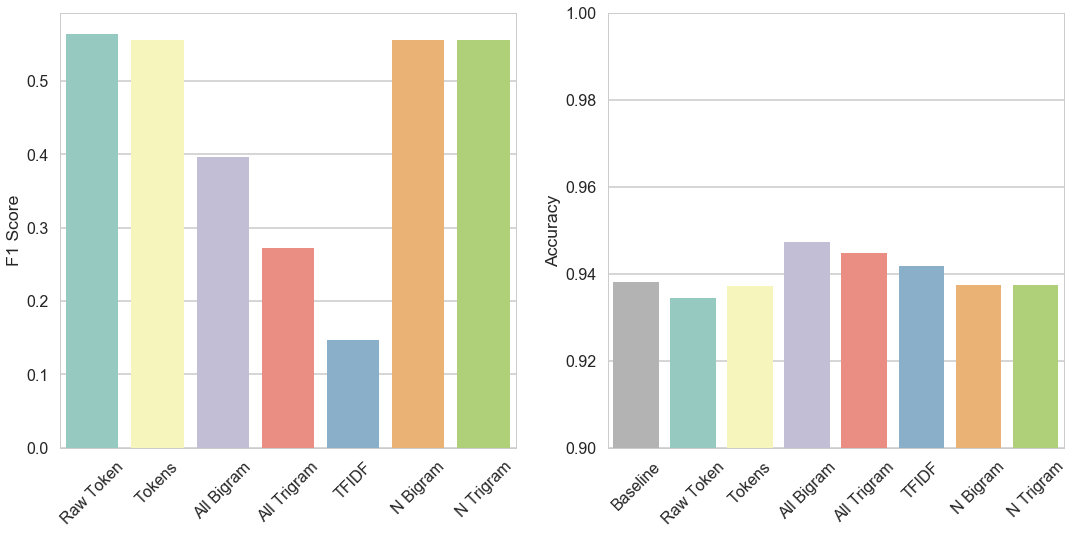

In [371]:
fig, ax = plt.subplots(1,2, figsize=(18,8))

ax1 = plt.subplot(121)
ax1 = sns.barplot(x=f1_df.index, y=f1_df['F1 Score'], palette=f1_hue)
ax1 = plt.xticks(rotation=45)

ax2 = plt.subplot(122)
ax2 = sns.barplot(x=acc_df.index, y=acc_df.Accuracy, palette=acc_hue)
ax1 = plt.ylim(0.9, 1)
ax2 = plt.xticks(rotation=45)




In [328]:
sns.choose_colorbrewer_palette( 'qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

[(0.8941176470588235, 0.10196078431372557, 0.10980392156862737),
 (0.21568627450980393, 0.4941176470588236, 0.7215686274509804),
 (0.3019607843137256, 0.6862745098039216, 0.29019607843137263),
 (0.5960784313725492, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (0.9999999999999998, 1.0, 0.19999999999999996),
 (0.6509803921568629, 0.33725490196078434, 0.1568627450980391),
 (0.9686274509803922, 0.5058823529411766, 0.7490196078431374),
 (0.6, 0.6, 0.6)]

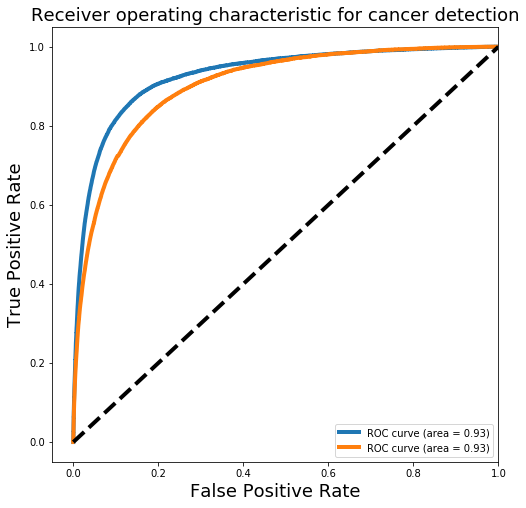

In [254]:
# For class 1, find the area under the curve
fpr_raw, tpr_raw, _ = roc_curve(y_test_raw, Y_pp.raw_class_1_pp)
fpr_t, tpr_t, _ = roc_curve(y_test, Y_pp_t.t_class_1_pp)
fpr_tfidf, tpr_tfidf, _ = roc_curve(y_test, Y_pp_tfidf.tfidf_class_1_pp)

roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])


plt.plot(fpr_raw, tpr_raw, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
# plt.plot(fpr_t, tpr_t, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot(fpr_tfidf, tpr_tfidf, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)


plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()